# Extract variables from OCO-2 dataset

In [174]:
# to display plots in notebook
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 300  # high res plots
rcParams["font.size"] = 8

import warnings
warnings.filterwarnings('ignore')

## Import packages

In [175]:
import matplotlib.pyplot as plt # plots
import cartopy.crs as ccrs      # map projections
import pandas as pd             # large arrays
import numpy as np              # large arrays and matrices
import xarray as xr             # major tool to work with NetCDF data!
# custom color map downloaded from GEOS-Chem python tutorial
from gamap_colormap import WhGrYlRd  # import the "WhGrYlRd" variable
import re

In [176]:
# settings
# file names and paths
input_file = './OCO2_b91_10sec_GOOD_r24.nc4'
output_file ='./OCO2_extract.nc'

# first and last day of extraction
first_day = '2018-03-01'
last_day_p1 = '2018-04-01' # last day plus 1

# names of variables need to extract 
var_names  = ['xco2', 
              'psurf', 
              'xco2_averaging_kernel']

In [177]:
ds = xr.open_dataset(input_file, engine='netcdf4')
sel1 = ds['xco2_averaging_kernel'].sel(sounding_id = sound_slice) # same as print(ds)
ds #['xco2_averaging_kernel'].name

<xarray.Dataset>
Dimensions:                       (epoch_dimension: 7, levels: 20, sounding_id: 1319634)
Coordinates:
  * sounding_id                   (sounding_id) int64 20140906020721 ... 20190731225946
Dimensions without coordinates: epoch_dimension, levels
Data variables:
    test_flag                     (sounding_id) int8 ...
    latitude                      (sounding_id) float32 ...
    longitude                     (sounding_id) float32 ...
    data_type                     (sounding_id) int8 ...
    date                          (sounding_id, epoch_dimension) int16 ...
    time                          (sounding_id) datetime64[ns] ...
    solar_zenith_angle            (sounding_id) float32 ...
    solar_azimuth_angle           (sounding_id) float32 ...
    sensor_zenith_angle           (sounding_id) float32 ...
    sensor_azimuth_angle          (sounding_id) float32 ...
    psurf_apriori_b8              (sounding_id) float32 ...
    psurf_apriori_o2a             (sounding_id) float32 ...
    psurf_apriori_wco2            (sounding_id) float32 ...
    psurf_apriori_sco2            (sounding_id) float32 ...
    psurf_apriori                 (sounding_id) float32 ...
    psurf                         (sounding_id) float32 ...
    xco2_raw                      (sounding_id) float32 ...
    xco2_apriori                  (sounding_id) float32 ...
    xco2                          (sounding_id) float32 ...
    xco2_uncertainty              (sounding_id) float32 ...
    model_error                   (sounding_id) float32 ...
    co2_profile_apriori           (sounding_id, levels) float32 ...
    xco2_averaging_kernel         (sounding_id, levels) float32 ...
    pressure_weight               (sounding_id, levels) float32 ...
    sigma_levels                  (levels) float32 ...
    xco2_quality_flag             (sounding_id) int8 ...
    warn_level                    (sounding_id) int8 ...
    land_fraction                 (sounding_id) int8 ...
    altitude                      (sounding_id) float32 ...
    airmass                       (sounding_id) float32 ...
    path                          (sounding_id) int16 ...
    operation_mode                (sounding_id) int8 ...
    land_water_indicator          (sounding_id) int8 ...
    surface_type                  (sounding_id) int8 ...
    fs                            (sounding_id) float32 ...
    delta_windspeed               (sounding_id) float32 ...
    s31                           (sounding_id) float32 ...
    s32                           (sounding_id) float32 ...
    albedo_3                      (sounding_id) float32 ...
    albedo_slope_3                (sounding_id) float32 ...
    aod_total                     (sounding_id) float32 ...
    albedo_2                      (sounding_id) float32 ...
    co2_grad_del                  (sounding_id) float32 ...
    dws                           (sounding_id) float32 ...
    dpfrac                        (sounding_id) float32 ...
    dp_o2a                        (sounding_id) float32 ...
    dp                            (sounding_id) float32 ...
    dp_abp                        (sounding_id) float32 ...
    co2_ratio                     (sounding_id) float32 ...
    h2o_ratio                     (sounding_id) float32 ...
    xco2_weak_idp                 (sounding_id) float32 ...
    xco2_strong_idp               (sounding_id) float32 ...
    tcwv_apriori                  (sounding_id) float32 ...
    tcwv                          (sounding_id) float32 ...
    ice_height                    (sounding_id) float32 ...
    h2o_scale                     (sounding_id) float32 ...
    deltaT                        (sounding_id) float32 ...
    snr_o2a                       (sounding_id) float32 ...
    snr_wco2                      (sounding_id) float32 ...
    snr_sco2                      (sounding_id) float32 ...
    altitude_stddev               (sounding_id) float32 ...
    N_total_shots                 (sounding_id

In [178]:
# convert time input to match the format of sound_id
first_day_digital = re.sub("[^0-9]", "", first_day)
last_day_p1_digital = re.sub("[^0-9]", "", last_day_p1)
begin = int(first_day_digital + '000000')  # begin and end of time slice we want to look at
end = int(last_day_p1_digital + '000000')  # OCO-2 format
print('begining sound id of extraction: ' + str(begin))
print('end: ' + str(end))

begining sound id of extraction: 20180301000000
end: 20180401000000


In [179]:
# get a slice of data within begin and end
ds_slice = ds.sel(sounding_id=slice(begin,end)) # xarray Dataset

In [180]:
lon_series = ds_slice['longitude']              # lon and lat position, 1d
lat_series = ds_slice['latitude']
sound_id   = ds_slice['sounding_id']            # sound id, 1d
sigma      = ds['sigma_levels']                 # sigma levels, 20 values
# xarray dataarray

In [181]:
# position dataframe, used in for loops to locate
df_position = pd.DataFrame({'sound_id': sound_id, 
                            'lon': lon_series, 
                            'lat': lat_series})
len(df_position) #.head()

26772

In [182]:
# Creat target dataarray and dataset
lat_res = 2    # horizontal resolution of lat and lon you would want
lon_res = 2.5
lat = np.linspace(-90, 90, int(180/lat_res + 1)) # grid
lon = np.linspace(-180, 177.5, int(360/lon_res))
levels = ds_slice.sigma_levels.values

day_1   = np.array(first_day,dtype='datetime64[D]')
day_end = np.array(last_day_p1,dtype='datetime64[D]')
days    = np.arange(day_1, day_end, dtype='datetime64[D]') # time dimension of output

var_3d = xr.DataArray(data = 0, 
                      dims = ('lat', 'lon', 'time'), 
                      coords = {'lat': lat,
                                'lon': lon,
                                'time': days},
                      name = '')
var_3d = var_3d.astype(dtype='float32')

var_4d = xr.DataArray(data = 0, 
                      dims = ('lat', 'lon', 'time', 'levels'), 
                      coords = {'lat': lat,
                                'lon': lon,
                                'time': days,
                                'levels': levels},
                      name = 'xco2_averaging_kernel')

var_4d = var_4d.astype(dtype='float32')
oco2 = var_4d.to_dataset() # initialise a dataset to store all dataarrays

In [183]:
days_range = np.arange(first_day, last_day_p1, dtype='datetime64[D]')
days_range

array(['2018-03-01', '2018-03-02', '2018-03-03', '2018-03-04',
       '2018-03-05', '2018-03-06', '2018-03-07', '2018-03-08',
       '2018-03-09', '2018-03-10', '2018-03-11', '2018-03-12',
       '2018-03-13', '2018-03-14', '2018-03-15', '2018-03-16',
       '2018-03-17', '2018-03-18', '2018-03-19', '2018-03-20',
       '2018-03-21', '2018-03-22', '2018-03-23', '2018-03-24',
       '2018-03-25', '2018-03-26', '2018-03-27', '2018-03-28',
       '2018-03-29', '2018-03-30', '2018-03-31'], dtype='datetime64[D]')

In [184]:
# map to target grid and store in dataset
for ivar in var_names:
    print(ivar)
    nm_dim = len(ds[ivar].dims)
    var_3d[:,:,:] = 0
    var_4d[:,:,:,:] = 0
    
    for iday in np.arange(len(days_range)-1):
        day1=re.sub("[^0-9]", "", str(days_range[iday]))
        day2=re.sub("[^0-9]", "", str(days_range[iday+1]))
        begin = int(str(day1) + '000000')  # begin and end of time slice we want to look at
        end = int(str(day2) + '000000')  # OCO-2 format
        # get a slice of position data within a day
        df_time_slice = df_position[df_position['sound_id'].between(begin, end)]
        
        for ilat in np.arange(len(lat)-1):
            # get a slice of position data within a degree of latitude band
            df_slice_lat = df_time_slice[df_time_slice['lat'].between(lat[ilat]-0.5*lat_res,lat[ilat]+0.5*lat_res, inclusive = True)]
            
            for ilon in np.arange(len(lon)-1):
                # get a slice of position data within a degree of longitude band, i.e. a grid cell in one day
                df_slice_lon = df_slice_lat[df_slice_lat['lon'].between(lon[ilon]-0.5*lon_res,lon[ilon]+0.5*lon_res, inclusive = True)]
            
                if len(df_slice_lon) != 0: # check if zero
                    sound_slice = df_slice_lon.sound_id.values # localtion of points, in sound id                
                    var_slice = ds[ivar].sel(sounding_id=sound_slice)
                    
                    if(len(var_slice.dims) == 1):
                        var_3d[ilat,ilon,iday] = var_slice.mean().values
                    else:
                        var_4d[ilat,ilon,iday,:] = var_slice.mean(dim='sounding_id').values
                        
        print(days_range[iday])
        
    if(nm_dim == 1):
        oco2[ivar] = var_3d.copy(deep=True)
    else:
        oco2[ivar] = var_4d.copy(deep=True)

xco2
2018-03-01
2018-03-02
2018-03-03
2018-03-04
2018-03-05
2018-03-06
2018-03-07
2018-03-08
2018-03-09
2018-03-10
2018-03-11
2018-03-12
2018-03-13
2018-03-14
2018-03-15
2018-03-16
2018-03-17
2018-03-18
2018-03-19
2018-03-20
2018-03-21
2018-03-22
2018-03-23
2018-03-24
2018-03-25
2018-03-26
2018-03-27
2018-03-28
2018-03-29
2018-03-30
psurf
2018-03-01
2018-03-02
2018-03-03
2018-03-04
2018-03-05
2018-03-06
2018-03-07
2018-03-08
2018-03-09
2018-03-10
2018-03-11
2018-03-12
2018-03-13
2018-03-14
2018-03-15
2018-03-16
2018-03-17
2018-03-18
2018-03-19
2018-03-20
2018-03-21
2018-03-22
2018-03-23
2018-03-24
2018-03-25
2018-03-26
2018-03-27
2018-03-28
2018-03-29
2018-03-30
xco2_averaging_kernel
2018-03-01
2018-03-02
2018-03-03
2018-03-04
2018-03-05
2018-03-06
2018-03-07
2018-03-08
2018-03-09
2018-03-10
2018-03-11
2018-03-12
2018-03-13
2018-03-14
2018-03-15
2018-03-16
2018-03-17
2018-03-18
2018-03-19
2018-03-20
2018-03-21
2018-03-22
2018-03-23
2018-03-24
2018-03-25
2018-03-26
2018-03-27
2018-03-28

In [185]:
oco2 #.xco2[:,:,0,2].plot()

<xarray.Dataset>
Dimensions:                (lat: 91, levels: 20, lon: 144, time: 31)
Coordinates:
  * lat                    (lat) float64 -90.0 -88.0 -86.0 ... 86.0 88.0 90.0
  * lon                    (lon) float64 -180.0 -177.5 -175.0 ... 175.0 177.5
  * time                   (time) datetime64[ns] 2018-03-01 ... 2018-03-31
  * levels                 (levels) float32 1e-04 0.05263158 ... 0.94736844 1.0
Data variables:
    xco2_averaging_kernel  (lat, lon, time, levels) float32 0.0 0.0 ... 0.0 0.0
    xco2                   (lat, lon, time) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    psurf                  (lat, lon, time) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0

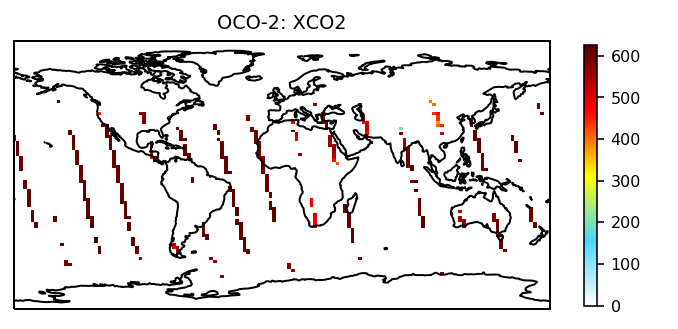

In [186]:
# plot after mapping
fig = plt.figure(figsize=[6, 6])
proj=ccrs.PlateCarree()

ax = plt.subplot(111, projection=proj)
ax.coastlines()
tmp = oco2['psurf'] - oco2['xco2']
tmp.isel(time=0).plot(ax=ax, transform=ccrs.PlateCarree(), cmap=WhGrYlRd, cbar_kwargs={'shrink': 0.4, 'label': ' '})

ax.set_title('OCO-2: XCO2');

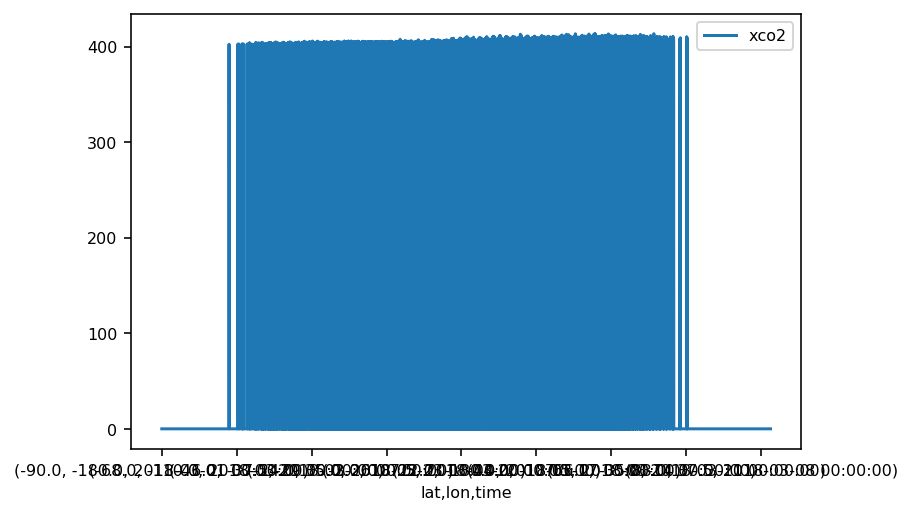

In [187]:
tmp = oco2.xco2.to_dataframe()
len(tmp)
tmp.plot()

In [189]:
oco2.to_netcdf(output_file)